In [116]:
# Data handling
import datetime as dt
import geopandas as gpd
import numpy as np
import os
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Custom functions
from scripts.common_functions import python_setup, get_mms_data, save_figure

# Set up Python
working_dir, charts_dir, data_dir = python_setup(dark_mode=False)

In [117]:
# Load data
raw_asx_data = pd.read_excel(
    os.path.join(data_dir, "asx_data", "aer_data.xlsx"),
    header=(0, 1))
# Clean data
asx_data = pd.DataFrame(
    columns=["Quarter", "Region", "Contract", "Volume"])
for i, row in raw_asx_data.iterrows():
    # Establish quarter
    if pd.notna(row[row.index[0]]):
        year = int(row[row.index[0]])
    quarter_no = int(row[row.index[1]])
    quarter = dt.datetime(year, quarter_no * 3, 1) + pd.offsets.MonthEnd()
    # Establish contract and region
    for column in row.index[2:]:
        region = column[0]
        contract = column[1][0] + column[1][1:].lower()
        volume = row[column]
        asx_data.loc[len(asx_data)] = [
            quarter,
            region,
            contract,
            volume]

trade_data = asx_data.pivot_table(
    index="Quarter",
    columns="Contract",
    values="Volume",
    aggfunc="sum")
trade_data = trade_data.loc["2020-07-01":"2025-06-30"] / 1000000
trade_data["Base"] = trade_data["Base quarterly"] + trade_data["Base monthly"]
trade_data = trade_data.iloc[:, [0, 3, 4, 5, 6]]
trade_data = trade_data[trade_data.iloc[-1].sort_values(ascending=False).index]
trade_data

Contract,Swaption,Base,Avg rate option,Cap,Peak
Quarter,,,,,
2020-09-30,136.211040,66.315408,14.371344,7.806360,0.415665
2020-12-31,124.614720,98.141928,10.313664,10.989864,0.138105
2021-03-31,190.364040,74.912112,18.233208,11.599560,0.086520
2021-06-30,124.460880,132.393960,18.691704,32.014968,0.027060
2021-09-30,119.036040,86.131536,17.046912,17.732088,0.400170
2021-12-31,143.033448,122.438832,11.511912,21.731832,0.047760
2022-03-31,201.506232,109.759488,15.243720,21.718992,0.006675
2022-06-30,160.050384,155.487840,9.003336,14.352504,0.033405
2022-09-30,116.225184,73.322832,4.446960,9.754728,0.040755


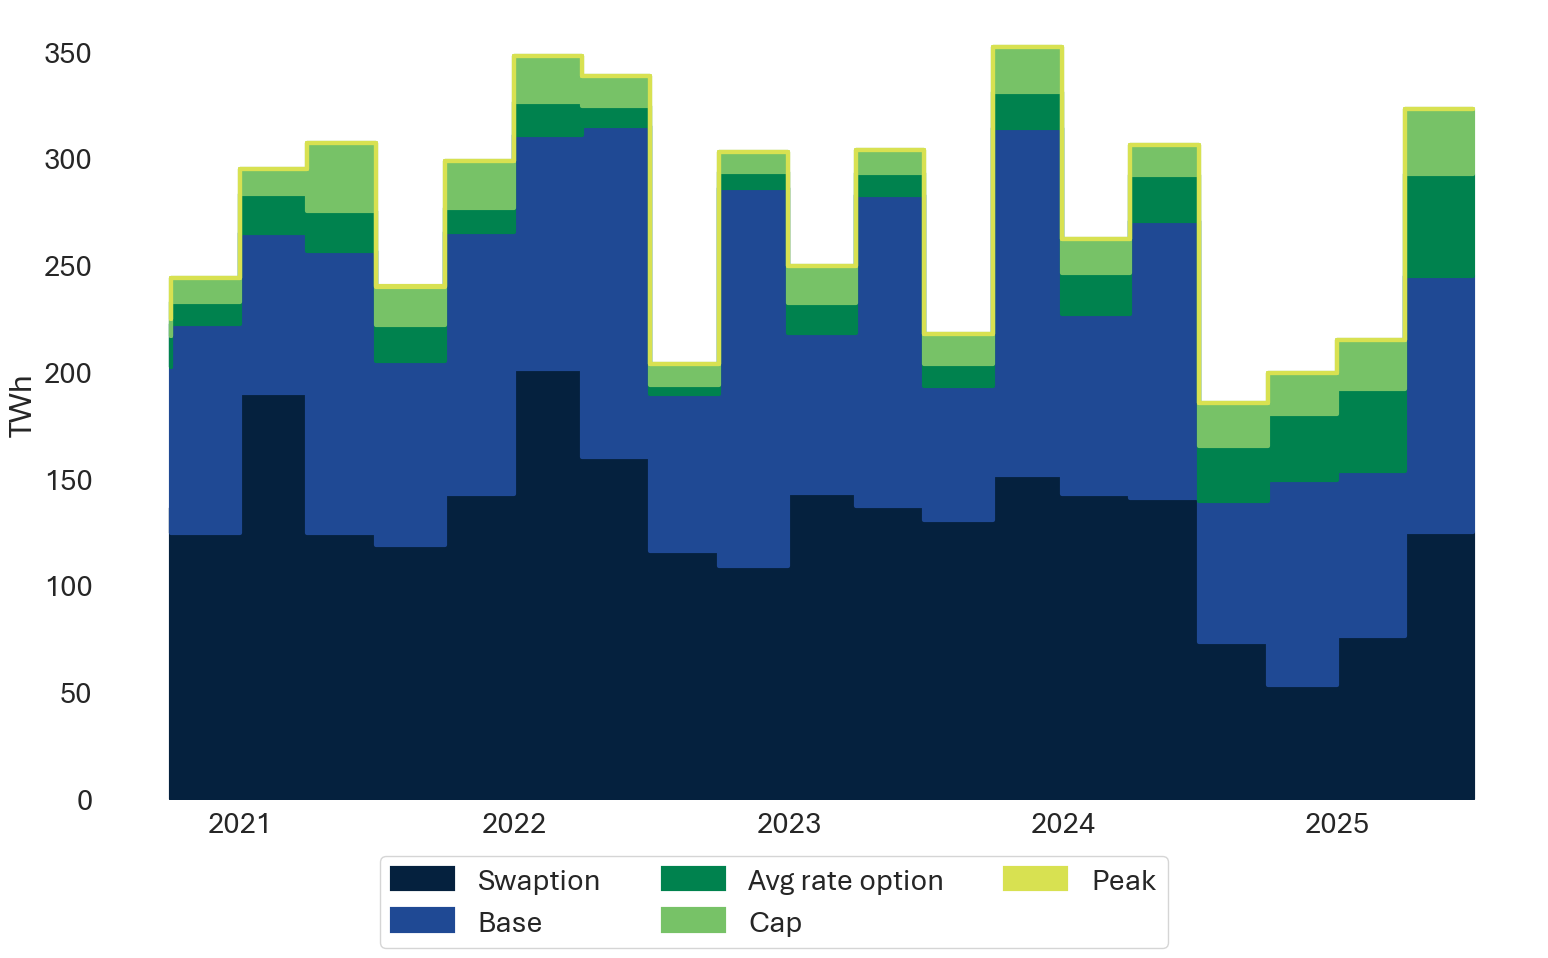

In [129]:
# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
chart_data = trade_data.cumsum(axis=1)

for i, contract in enumerate(chart_data.columns):
    ax.fill_between(
        x=chart_data.index,
        y1=(0 if i == 0 else chart_data[chart_data.columns[i - 1]]),
        y2=chart_data[contract],
        linewidth=3,
        color=f"C{i}",
        label=contract,
        step="pre")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel(None)
plt.ylabel("TWh")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylim(0)
fig.patch.set_alpha(0.0)
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncols=3)
plt.show()

In [130]:
open_interest_data = pd.read_csv(
    os.path.join(data_dir, "asx_data", "open_interest.tsv"),
    sep="\t",
    usecols=[0, 1, 2, 3, 4, 5],
    parse_dates=[0],
    dayfirst=True,
    index_col=0)
open_interest_data.rename(columns={"Base future": "Base", "Average rate option": "Avg rate option"}, inplace=True)
open_interest_data = open_interest_data.resample("QE").mean().loc["2020-06-30":"2025-06-30"]
open_interest_data

,Base,Cap,Peak,Avg rate option,Swaption
Date,,,,,
2020-06-30,94.451613,17.532258,1.629032,18.774194,140.096774
2020-09-30,97.015152,15.636364,2.000000,22.757576,182.621212
2020-12-31,103.578125,15.109375,1.000000,23.625000,213.000000
2021-03-31,106.161290,13.500000,1.000000,22.016129,239.870968
2021-06-30,104.177419,16.290323,1.000000,22.596774,266.000000
2021-09-30,114.924242,24.939394,1.000000,30.969697,297.878788
2021-12-31,118.906250,30.296875,1.000000,27.968750,316.437500
2022-03-31,127.661290,35.274194,1.000000,23.758065,371.693548
2022-06-30,136.983607,32.803279,1.000000,22.426230,445.967213


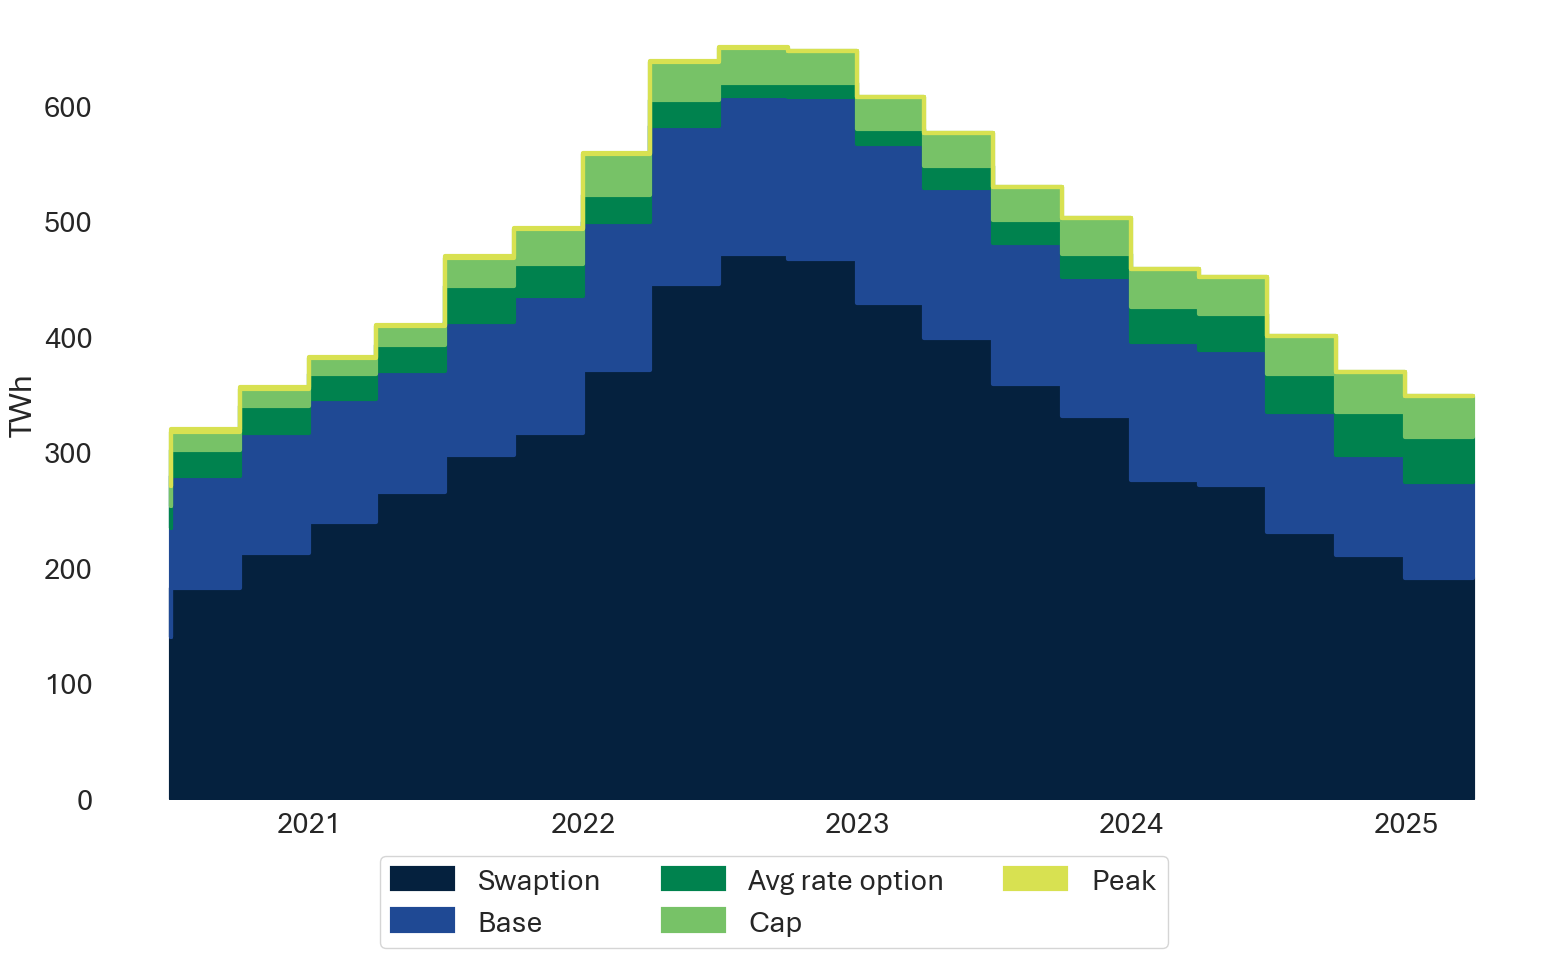

In [131]:
# Plot chart
fig, ax = plt.subplots(
    figsize=(16, 9),
    tight_layout=True)
chart_data = open_interest_data[trade_data.columns].cumsum(axis=1)

for i, contract in enumerate(chart_data.columns):
    ax.fill_between(
        x=chart_data.index,
        y1=(0 if i == 0 else chart_data[chart_data.columns[i - 1]]),
        y2=chart_data[contract],
        linewidth=3,
        color=f"C{i}",
        label=contract,
        step="pre")
for frame in ["top", "right", "bottom", "left"]:
    ax.spines[frame].set_visible(False)
handles, labels = ax.get_legend_handles_labels()
plt.xlabel(None)
plt.ylabel("TWh")
ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
plt.ylim(0)
fig.patch.set_alpha(0.0)
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncols=3)
plt.show()

In [ ]:
import time

asx_data = pd.read_csv(
    os.path.join(data_dir, "asx_data", "asx_data.csv"),
    parse_dates=[0],
    index_col=0)
data = pd.DataFrame(
    columns=["Date", "Region", "Contract", "Year", "Period", "Measure", "Value"])
start = time.time()
interval = 2
print(f"Processing data ...", end="\r")
for i, col in enumerate(asx_data.columns):
    strings = col.split(" ")[3:]
    region, year, period = strings[:3]
    contract = "Cap" if "Cap" in strings else "Base"
    measure = "Open interest" if "Interest" in strings else "Volume"
    for d in asx_data.index:
        row = [
            d,
            region,
            contract,
            int(year),
            period,
            measure,
            asx_data.at[d, col]]
        data.loc[len(data)] = row
    if time.time() - start > interval:
        interval = interval + 2
        print(f"Processing data ... {i + 1} of {asx_data.shape[1]}", end="\r")
print(f"Processing data ... complete")
data

Processing data ... complete


,Date,Region,Contract,Year,Period,Measure,Value
0,2023-07-03 17:00:00,NSW,Cap,2023,Q3,Volume,1.0
1,2023-07-04 17:00:00,NSW,Cap,2023,Q3,Volume,2.0
2,2023-07-05 17:00:00,NSW,Cap,2023,Q3,Volume,0.0
3,2023-07-06 17:00:00,NSW,Cap,2023,Q3,Volume,0.0
4,2023-07-07 17:00:00,NSW,Cap,2023,Q3,Volume,2.0
...,...,...,...,...,...,...,...
12770,2025-06-24 17:00:00,NSW,Cap,2025,Q4,Open interest,774.0
12771,2025-06-25 17:00:00,NSW,Cap,2025,Q4,Open interest,770.0
12772,2025-06-26 17:00:00,NSW,Cap,2025,Q4,Open interest,770.0
12773,2025-06-27 17:00:00,NSW,Cap,2025,Q4,Open interest,770.0


In [ ]:
# Plot chart
fig, ax = plt.subplots(
    3, 1,
    figsize=(8, 9),
    tight_layout=True,
    sharex=True)

for i, state in enumerate(["NSW", "QLD", "VIC"]):
    axis = ax[i]
    state_data = data[data["Region"] == state]
    for measure in ["Volume", "Open interest"]:
        measure_data = state_data[state_data["Measure"] == measure][["Date", "Value"]]
        if measure == "Volume":
            measure_data = measure_data.set_index("Date").resample("ME").sum()
        else:
            measure_data = measure_data.set_index("Date").resample("ME").mean()
        axis.step(
            x=measure_data.index,
            y=measure_data["Value"],
            where="pre",
            color=("C0" if measure == "Volume" else "C1"),
            linewidth=3,
            linestyle=("solid" if measure == "Volume" else "dashed"),
            label=measure)        
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    ax.set_ylim(0)
handles, labels = axis.get_legend_handles_labels()
fig.legend(
    handles=handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncols=2)
plt.show()

In [ ]:
# Get native demand data
raw_demand_data = get_mms_data(
    "native_demand",
    {"start_date": "2020-07-01",
     "end_date": "2025-06-30"})
# Correct 5-minute lag
raw_demand_data["Interval"] = raw_demand_data["Interval"] - pd.DateOffset(minutes=5)
# Convert from MW to MWh
raw_demand_data["Native demand (MWh)"] = raw_demand_data["Native demand"] / 12
demand_data = raw_demand_data.pivot_table(
    index="Interval",
    columns="Region",
    values="Native demand (MWh)",
    aggfunc="sum").resample("QE").sum()
demand_data